In [1]:
code_dir = '../../../reference-matching-evaluation/'
data_dir = 'data/'
img_dir = 'images/'

In [2]:
import sys
sys.path.append(code_dir)

%matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
import re
import tarfile
import utils.data_format_keys as dfk

from dataset.dataset_utils import get_target_test_doi, get_target_gt_doi
from evaluation.link_metrics import LinkMetricsResults
from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import mcnemar
from utils.utils import read_json
from utils.cr_utils import generate_unstructured

In [3]:
def iterate_files(filename):
    tar = tarfile.open(filename, "r:gz")
    for member in tar:
        f = tar.extractfile(member)
        if f is not None:
            yield json.load(f)

def iterate_items(filename):
    for f in iterate_files(filename):
        for item in f['items']:
            yield item

In [4]:
i = 0
summary = {'all': 0, 'is_unstr': 0, 'is_str': 0, 'is_both': 0, 'has_p_doi': 0, 'empty': 0,
           'less_than_4': 0, 'no_title': 0}
for item in iterate_items("/srv/data/snapshots/data-2019-04.tar.gz"):
    i = i+1
    if i % 500000 == 0:
        print(i)
    references = item.get('reference', [])
    for r in references:
        summary['all'] += 1
        if 'publisher' == r.get('doi-asserted-by', ''):
            summary['has_p_doi'] += 1
        else:
            fields = [k for k in r.keys() if k not in ['key', 'DOI', 'unstructured', 'doi-asserted-by']]
            if fields and 'article-title' not in fields:
                summary['no_title'] += 1
            if fields and len(fields) < 4:
                summary['less_than_4'] += 1
            if 'unstructured' in r and not fields:
                summary['is_unstr'] += 1
            elif 'unstructured' in r and fields:
                summary['is_both'] += 1
            elif fields:
                summary['is_str'] += 1
            else:
                summary['empty'] += 1

500000
1000000
1500000
2000000
2500000
3000000
3500000
4000000
4500000
5000000
5500000
6000000
6500000
7000000
7500000
8000000
8500000
9000000
9500000
10000000
10500000
11000000
11500000
12000000
12500000
13000000
13500000
14000000
14500000
15000000
15500000
16000000
16500000
17000000
17500000
18000000
18500000
19000000
19500000
20000000
20500000
21000000
21500000
22000000
22500000
23000000
23500000
24000000
24500000
25000000
25500000
26000000
26500000
27000000
27500000
28000000
28500000
29000000
29500000
30000000
30500000
31000000
31500000
32000000
32500000
33000000
33500000
34000000
34500000
35000000
35500000
36000000
36500000
37000000
37500000
38000000
38500000
39000000
39500000
40000000
40500000
41000000
41500000
42000000
42500000
43000000
43500000
44000000
44500000
45000000
45500000
46000000
46500000
47000000
47500000
48000000
48500000
49000000
49500000
50000000
50500000
51000000
51500000
52000000
52500000
53000000
53500000
54000000
54500000
55000000
55500000
56000000
56500000
570

In [5]:
for k, v in summary.items():
    print(k, v/summary['all'])

all 1.0
is_unstr 0.10891732802731131
is_str 0.42701028443296735
is_both 0.17355914746673606
has_p_doi 0.2875628659747623
empty 0.002950374098222957
less_than_4 0.08822460738110872
no_title 0.4579691638251362


In [6]:
float(summary['no_title'])/(summary['is_str']+summary['is_both'])

0.762558231404655

In [7]:
float(summary['less_than_4'])/(summary['is_str']+summary['is_both'])

0.14690159487811305

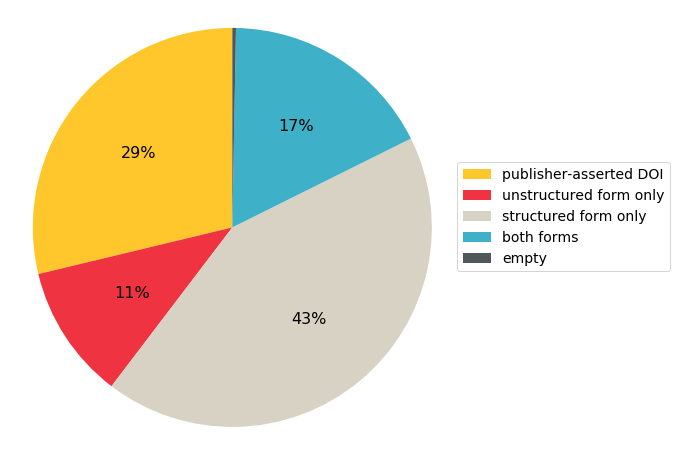

In [8]:
labels = ['publisher-asserted DOI', 'unstructured form only', 'structured form only', 'both forms', 'empty']
sizes = [0.287563, 0.108917, 0.427010, 0.173559, 0.002950]
colors = ['#ffc72c', '#ef3340', '#d8d2c4', '#3eb1c8', '#4f5858']
plt.rcParams.update({'font.size': 16, 'legend.fontsize': 14}) 
plt.figure(figsize=(8, 8))
patches, _, _ = plt.pie(sizes, colors=colors, startangle=90, autopct=lambda x: '' if x < 1 else '{}%'.format(int(x+0.5)))
plt.legend(patches, labels, loc=(1,0.4))
plt.axis('equal')
plt.savefig(img_dir + 'distribution.png', dpi=300, bbox_inches='tight')

In [9]:
dataset_ou = read_json(data_dir + 'dataset_ou.json')[dfk.DATASET_DATASET]
dataset_sbm = read_json(data_dir + 'dataset_sbm.json')[dfk.DATASET_DATASET]
dataset_sbmv = read_json(data_dir + 'dataset_sbmv.json')[dfk.DATASET_DATASET]
print('Dataset size: {}'.format(len(dataset_sbm)))

Dataset size: 2000


In [10]:
def modify_validation_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

def modify_relevance_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None \
            and item[dfk.DATASET_SCORE]/len(generate_unstructured(item[dfk.DATASET_REFERENCE])) < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

In [11]:
dataset_sbm = modify_relevance_threshold(dataset_sbm, 0.47)
dataset_sbmv = modify_validation_threshold(dataset_sbmv, 0.78)

In [12]:
def print_summary(dataset, name):
    link_results = LinkMetricsResults(dataset)
    print('{} precision: {:.4f} (CI at 95% {:.4f}-{:.4f})'
          .format(name, link_results.get(dfk.EVAL_PREC),
                  link_results.get(dfk.EVAL_CI_PREC)[0], link_results.get(dfk.EVAL_CI_PREC)[1]))
    print('{} recall: {:.4f} (CI at 95% {:.4f}-{:.4f})'
          .format(name, link_results.get(dfk.EVAL_REC),
                  link_results.get(dfk.EVAL_CI_REC)[0], link_results.get(dfk.EVAL_CI_REC)[1]))
    print('{} F1: {:.4f}'.format(name, link_results.get(dfk.EVAL_F1)))

print_summary(dataset_ou, 'OpenURL')
print()
print_summary(dataset_sbm, 'SBM')
print()
print_summary(dataset_sbmv, 'SBMV')

OpenURL precision: 0.9929 (CI at 95% 0.9882-0.9975)
OpenURL recall: 0.9280 (CI at 95% 0.9142-0.9418)
OpenURL F1: 0.9593

SBM precision: 0.6464 (CI at 95% 0.6241-0.6686)
SBM recall: 0.8508 (CI at 95% 0.8318-0.8698)
SBM F1: 0.7346

SBMV precision: 0.9831 (CI at 95% 0.9761-0.9901)
SBMV recall: 0.9495 (CI at 95% 0.9378-0.9612)
SBMV F1: 0.9660


In [13]:
def get_means(dataset):
    results = LinkMetricsResults(dataset)
    return [results.get(m) for m in [dfk.EVAL_PREC, dfk.EVAL_REC, dfk.EVAL_F1]]

def get_ci(dataset):
    results = LinkMetricsResults(dataset)
    ms = [results.get(m) for m in [dfk.EVAL_PREC, dfk.EVAL_REC]]
    return [[a-results.get(m)[0] for m, a in zip([dfk.EVAL_CI_PREC, dfk.EVAL_CI_REC], ms)] + [0],
            [results.get(m)[1]-a for m, a in zip([dfk.EVAL_CI_PREC, dfk.EVAL_CI_REC], ms)] + [0]]

def autolabel(ax, rects):
    plt.rcParams.update({'font.size': 14})
    for rect in rects:
        height = rect.get_height()
        text = '{:.2f}'.format(height)
        text = re.sub('\.00$', '', text)
        ax.text(rect.get_x() + rect.get_width()/2., 1.03*height, text, ha='center', va='bottom')

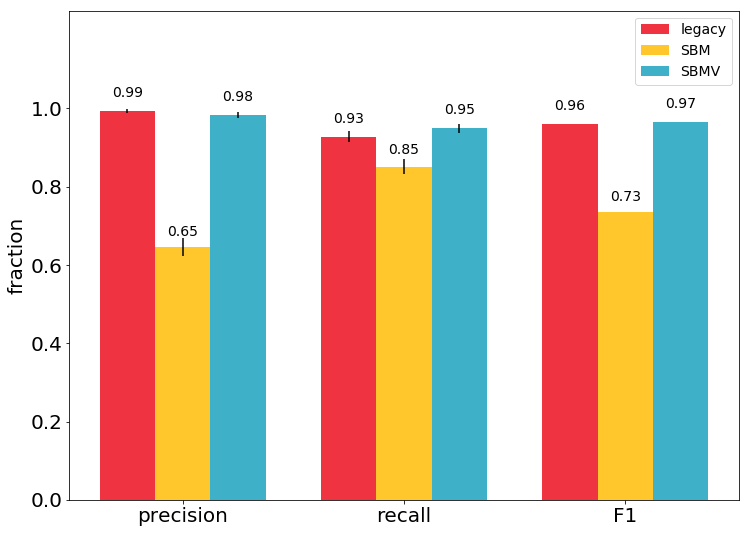

In [14]:
ind = np.arange(3)
width = 0.25
plt.rcParams.update({'font.size': 20, 'legend.fontsize': 14}) 
fig, ax = plt.subplots(figsize=(12, 9))

rects1 = ax.bar(ind - 0.5 * width, get_means(dataset_ou), yerr=get_ci(dataset_ou), width=width,
                color='#ef3340')
rects2 = ax.bar(ind + 0.5 * width, get_means(dataset_sbm), yerr=get_ci(dataset_sbm),
                width=width, color='#ffc72c')
rects3 = ax.bar(ind + 1.5 * width, get_means(dataset_sbmv), yerr=get_ci(dataset_sbmv),
                width=width, color='#3eb1c8')

ax.set_ylabel('fraction')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('precision', 'recall', 'F1'))
plt.ylim(0, 1.25)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.legend((rects1[0], rects2[0], rects3[0]), ('legacy', 'SBM', 'SBMV'))
autolabel(ax, rects1)
autolabel(ax, rects2)
autolabel(ax, rects3)

plt.savefig(img_dir + 'results.png', dpi=300, bbox_inches='tight')